In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!unzip '/content/drive/MyDrive/IndonesiaAI Computer Vision/IndonesiaAI_CityScapes.zip'

Archive:  /content/drive/MyDrive/IndonesiaAI Computer Vision/IndonesiaAI_CityScapes.zip
  inflating: images_prepped_test/0016E5_08071.png  
  inflating: images_prepped_test/0016E5_07979.png  
  inflating: images_prepped_test/0016E5_08043.png  
  inflating: images_prepped_test/0016E5_08039.png  
  inflating: images_prepped_test/0016E5_08021.png  
  inflating: images_prepped_test/0016E5_08051.png  
  inflating: images_prepped_test/0016E5_08013.png  
  inflating: images_prepped_test/0016E5_08007.png  
  inflating: images_prepped_test/0016E5_07975.png  
  inflating: images_prepped_test/0016E5_08119.png  
  inflating: images_prepped_test/0016E5_08047.png  
  inflating: images_prepped_test/0016E5_08141.png  
  inflating: images_prepped_test/0016E5_07983.png  
  inflating: images_prepped_test/0016E5_08079.png  
  inflating: images_prepped_test/0016E5_08127.png  
  inflating: images_prepped_test/0016E5_08019.png  
  inflating: images_prepped_test/0016E5_08069.png  
  inflating: images_prepped_

#### Import Library

In [3]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import torch
import torch.nn as nn
import keras.backend as K

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Cropping2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Metric
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

import warnings
warnings.filterwarnings('ignore')

#### Load Dataset

In [4]:
# dataset path
ROOT_DATASET = '/content'
os.listdir(ROOT_DATASET)

['.config',
 'images_prepped_test',
 'annotations_prepped_test',
 'drive',
 'images_prepped_train',
 'annotations_prepped_train',
 'sample_data']

In [5]:
img_path = ROOT_DATASET + '/images_prepped_train/'
annot_path = ROOT_DATASET + '/annotations_prepped_train/'
img_path_test = ROOT_DATASET + '/images_prepped_test/'
annot_path_test = ROOT_DATASET + '/annotations_prepped_test/'

In [6]:
train_images_dir = glob.glob(img_path+'/*.png')
train_annotations_dir = glob.glob(annot_path+'/*.png')
test_images_dir = glob.glob(img_path_test+'/*.png')
test_annotations_dir = glob.glob(annot_path_test+'/*.png')

In [7]:
IMAGE_SIZE = 224 #Change from 416

In [8]:
# data train
train_images = []
for img in train_images_dir:
    n = cv2.imread(img) #load image menggunakan opencv BGR
    x = cv2.resize(n, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
    train_images.append(x)
train_annotations = []
for img in train_annotations_dir:
    n = cv2.imread(img)
    x = cv2.resize(n, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
    train_annotations.append(x)

In [56]:
# data test
test_images = []
for img in test_images_dir:
    n = cv2.imread(img)
    x = cv2.resize(n, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
    test_images.append(x)
test_annotations = []
for img in test_annotations_dir:
    n = cv2.imread(img)
    x = cv2.resize(n, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
    test_annotations.append(x)

In [10]:
def changeToRGB(train_images_dir):
  result = []
  for img_gray in train_images_dir:
      n = cv2.imread(img_gray)
      gray_img = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
      x = cv2.resize(gray_img, (IMAGE_SIZE, IMAGE_SIZE)) # Resize to (224, 224)
      result.append(x)

  # Convert the gray_dataset list back to numpy array
  result = np.array(result)

  return result

In [58]:
def get_colored_segmentation_image(seg, colors,
                                    n_classes):
    """ Return a colored segmented image """
    seg_img = np.zeros_like(seg)

    for c in range(n_classes):
        seg_img[:, :, 0] += ((seg[:, :, 0] == c)
                             * (colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg[:, :, 0] == c)
                             * (colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg[:, :, 0] == c)
                             * (colors[c][2])).astype('uint8')
    return seg_img

# initiate fix colors list
class_colors = [(128,0,0), (170,110, 40), (128,128,0), (0,128,128), (0,0,128), (230,25,75), (245,130,48), (255,255,25), (210,245,60), (240,50,230),
               (128,128,128), (220,190,255), (255,215,180), (70,140,240), (0,130,200)]

In [12]:
plt.style.use('dark_background')

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "grey",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

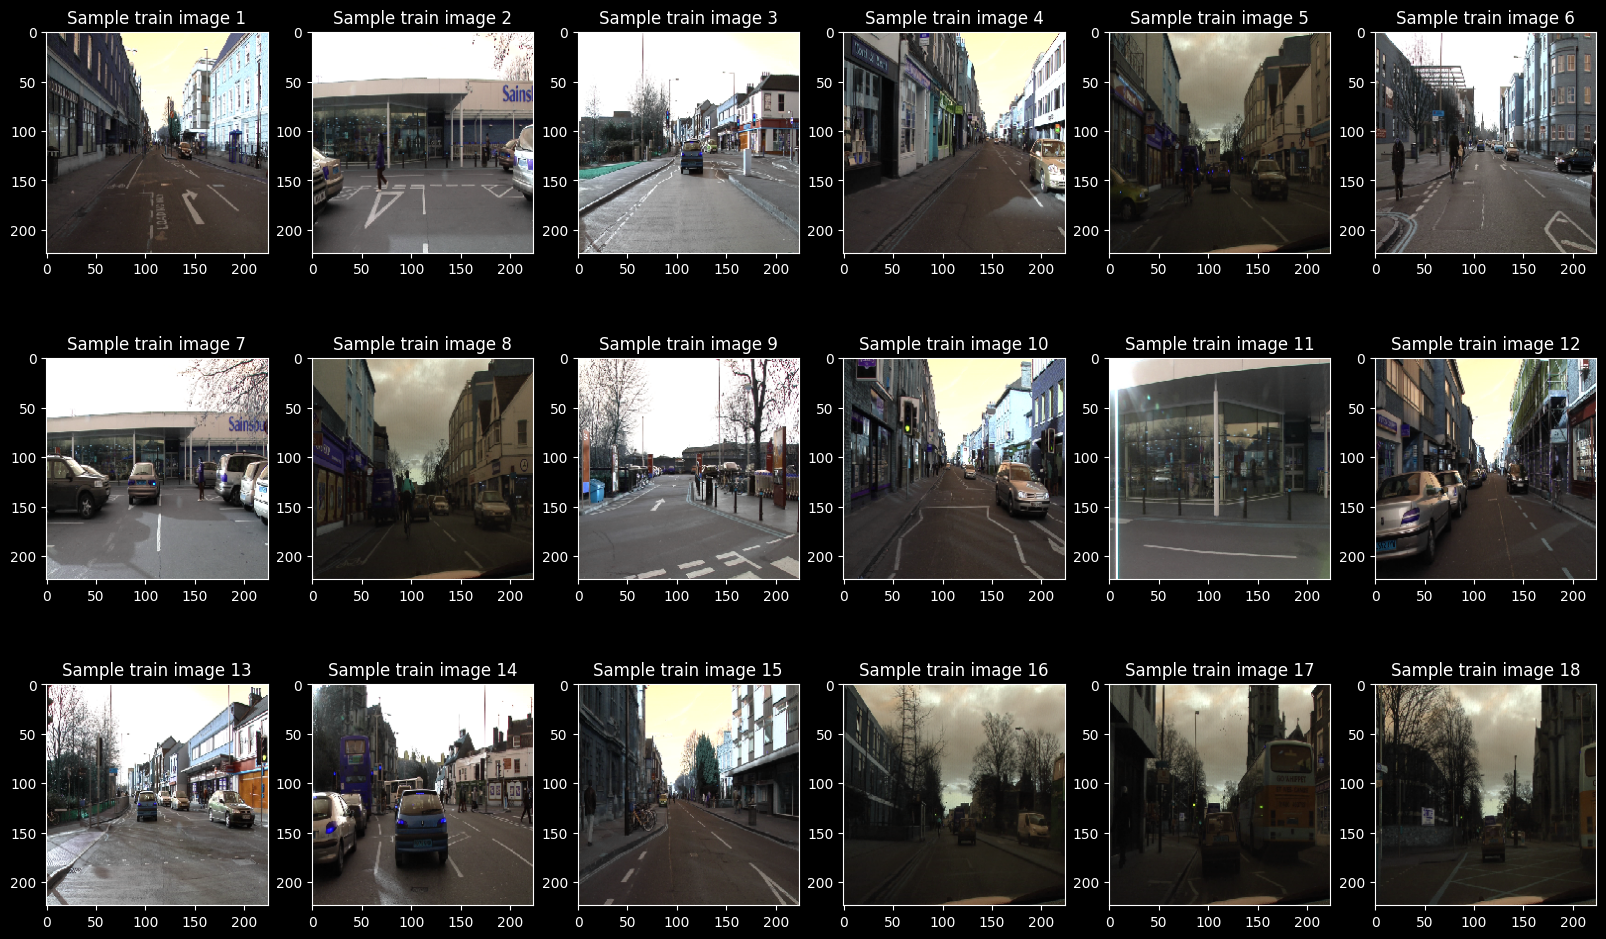

In [13]:
#Plot sample of train images
fig = plt.figure(figsize = (20,12))

for index in range(18):
    ax = fig.add_subplot(3,6,index+1)
    ax.set_title("Sample train image {}".format(index+1))
    ax.imshow(train_images[index])

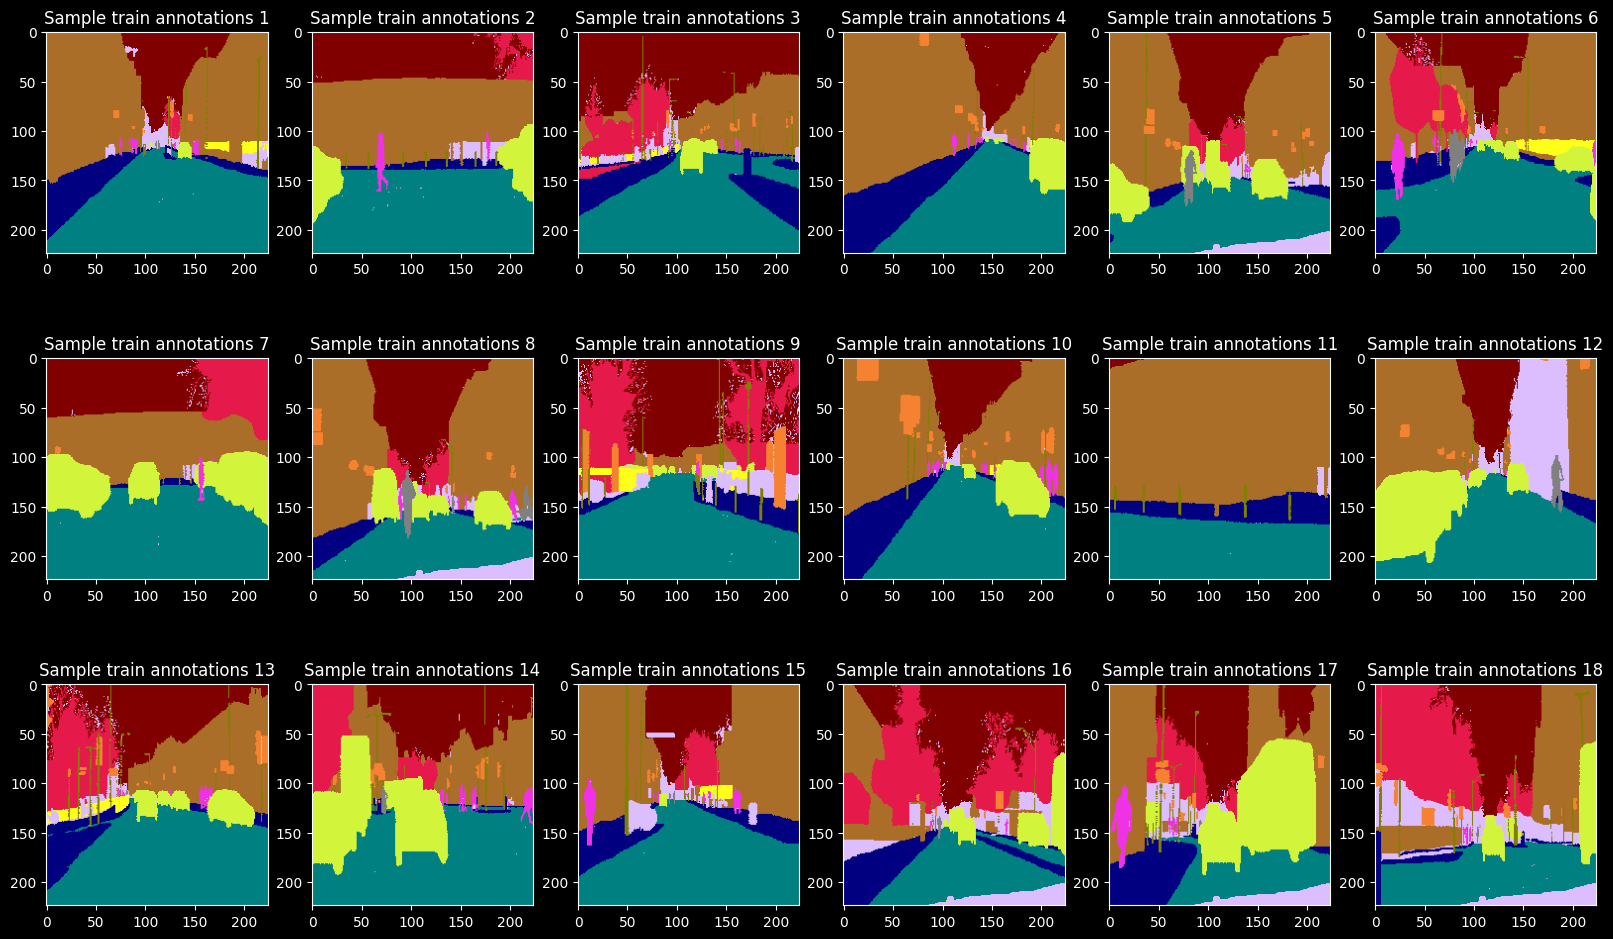

In [14]:
#Plot sample of train annotations
fig = plt.figure(figsize = (20,12))

for index in range(18):
    ax = fig.add_subplot(3,6,index+1)
    ax.set_title("Sample train annotations {}".format(index+1))
    ax.imshow(get_colored_segmentation_image(train_annotations[index],n_classes=12,colors=class_colors))

In [15]:
print("There are {} images in train images".format(len(os.listdir(img_path))))
print("\nThere are {} images in train annotations".format(len(os.listdir(annot_path))))
print("\nshape of one sample image in train images dataset: {}".format(train_images[0].shape))
print("\nshape of one sample image in train annotations dataset: {}".format(train_annotations[0].shape))

There are 367 images in train images

There are 367 images in train annotations

shape of one sample image in train images dataset: (224, 224, 3)

shape of one sample image in train annotations dataset: (224, 224, 3)


In [16]:
print("There are {} images in test images".format(len(os.listdir(img_path_test))))
print("\nThere are {} images in test annotations".format(len(os.listdir(annot_path_test))))
print("\nshape of one sample image in test images dataset: {}".format(test_images[0].shape))
print("\nshape of one sample image in test annotations dataset: {}".format(test_annotations[0].shape))

There are 101 images in test images

There are 101 images in test annotations

shape of one sample image in test images dataset: (224, 224, 3)

shape of one sample image in test annotations dataset: (224, 224, 3)


In [17]:
# change to RGB
train_x = []
test_x = []

train_x = changeToRGB(train_images_dir)
test_x = changeToRGB(test_images_dir)

In [18]:
print('train x', train_x.shape)
print('test x', test_x.shape)

train x (367, 224, 224, 3)
test x (101, 224, 224, 3)


In [19]:
train_y = []
test_y = []

train_y = np.array(train_annotations)[:,:,:,0]
test_y = np.array(test_annotations)[:,:,:,0]

np.unique(train_y), np.unique(test_y), train_y.shape, test_y.shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=uint8),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=uint8),
 (367, 224, 224),
 (101, 224, 224))

In [20]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

train_y.shape, test_y.shape

((367, 224, 224, 12), (101, 224, 224, 12))

## Evaluation

#### Dice Loss

In [21]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred, smooth=1):
    return 1.0 - (dice_coef(y_true, y_pred, smooth))

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

##Model and Training

#### UNet Model

In [46]:
def UNet(image_size, ch_in=3, ch_out=12):
  inputs = Input(shape=(*image_size, ch_in), name='input')

  # The Contraction Path
  # Blok 1
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

  # Blok 2
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

  # Blok 3
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

  # Blok 4
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

  # The Bottleneck Path
  # Blok 5
  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
  dropout5 = Dropout(0.5)(conv5) #Dropout sifatnya opsional

  # The Expansion Path
  # Blok 6
  up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(dropout5))
  merge6 = concatenate([conv4, up6], axis=3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

  # Blok 7
  up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv6))
  merge7 = concatenate([conv3, up7], axis=3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

  # Blok 8
  up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv7))
  merge8 = concatenate([conv2, up8], axis=3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

  # Blok 9
  up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv8))
  merge9 = concatenate([conv1, up9], axis=3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

  conv10 = Conv2D(ch_out, 1, activation='softmax')(conv9)

  outputs = conv10

  model = Model(inputs, outputs)

  return model

In [47]:
model_Unet = UNet(image_size=(IMAGE_SIZE, IMAGE_SIZE))

In [48]:
model_Unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 224, 224, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_43 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_42[0][0]']              
                                )                                                           

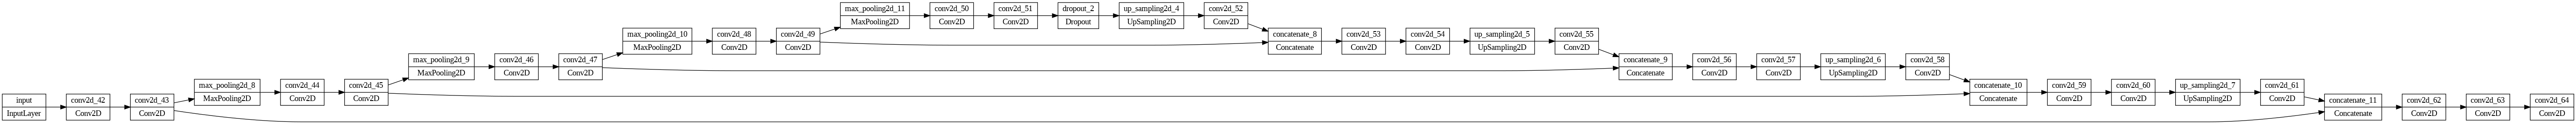

In [49]:
tf.keras.utils.plot_model(model_Unet, rankdir='LR')

In [50]:
model_Unet_checkpoint = keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/IndonesiaAI Computer Vision/temp/unet_model/unet_model.h5",
                                                            verbose=1,
                                                            save_best_only=True,
                                                            save_weights_only=True)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_Unet.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_loss, metrics=[dice_coef, 'accuracy', 'binary_accuracy', true_positive_rate])

# Train model
history_unet = model_Unet.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=100, batch_size=4, callbacks=[model_Unet_checkpoint, early_stopping])

Epoch 1/100
92/92 [==============================] - ETA: 0s - loss: 0.6965 - dice_coef: 0.3036 - accuracy: 0.3032 - binary_accuracy: 0.8850 - true_positive_rate: 0.3022
Epoch 1: val_loss improved from inf to 0.71278, saving model to /content/drive/MyDrive/IndonesiaAI Computer Vision/temp/unet_model/unet_model.h5
92/92 [==============================] - 30s 315ms/step - loss: 0.6965 - dice_coef: 0.3036 - accuracy: 0.3032 - binary_accuracy: 0.8850 - true_positive_rate: 0.3022 - val_loss: 0.7128 - val_dice_coef: 0.2869 - val_accuracy: 0.2872 - val_binary_accuracy: 0.8812 - val_true_positive_rate: 0.2869
Epoch 2/100
92/92 [==============================] - ETA: 0s - loss: 0.6622 - dice_coef: 0.3380 - accuracy: 0.3378 - binary_accuracy: 0.8896 - true_positive_rate: 0.3380
Epoch 2: val_loss improved from 0.71278 to 0.49243, saving model to /content/drive/MyDrive/IndonesiaAI Computer Vision/temp/unet_model/unet_model.h5
92/92 [==============================] - 29s 316ms/step - loss: 0.6622 -

#### FCN8 Model

In [27]:
def FCN8(image_size, ch_in=3, ch_out=12):
  inputs = Input(shape=(*image_size, ch_in), name='input')

  # Blok 1
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

  # Blok 2
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

  # Blok 3
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

  # Blok 4
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

  # Blok 5
  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
  dropout5 = Dropout(0.5)(conv5) # Dropout is optional

  # Blok 6
  up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(dropout5)
  merge6 = concatenate([conv4, up6], axis=3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

  # Block 7
  up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
  merge7 = concatenate([conv3, up7], axis=3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

  # Block 8
  up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
  merge8 = concatenate([conv2, up8], axis=3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

  # Block 9
  up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
  merge9 = concatenate([conv1, up9], axis=3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

  # Final convolution layer
  conv10 = Conv2D(ch_out, 1, activation='softmax')(conv9)

  model = Model(inputs=inputs, outputs=conv10)

  return model

In [28]:
model_FCN8 = FCN8(image_size=(IMAGE_SIZE, IMAGE_SIZE))

In [29]:
model_FCN8.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 224, 224, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_23[0][0]']              
                                )                                                           

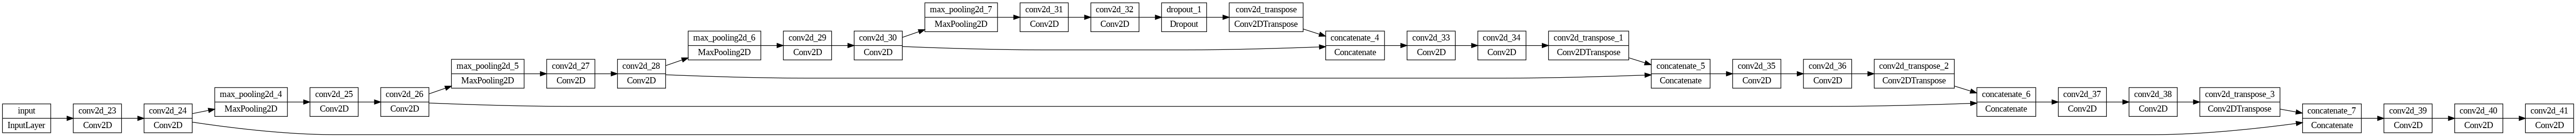

In [30]:
tf.keras.utils.plot_model(model_FCN8, rankdir='LR')

In [31]:
model_FCN8_checkpoint = keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/IndonesiaAI Computer Vision/temp/unet_model/fcn8_model.h5",
                                                            verbose=1,
                                                            save_best_only=True,
                                                            save_weights_only=True)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_FCN8.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_loss, metrics=[dice_coef, 'accuracy', 'binary_accuracy', true_positive_rate])

# Train model
history_fcn8 = model_FCN8.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=100, batch_size=4, callbacks=[model_FCN8_checkpoint, early_stopping])

Epoch 1/100
92/92 [==============================] - ETA: 0s - loss: 0.6764 - dice_coef: 0.3237 - accuracy: 0.3260 - binary_accuracy: 0.8901 - true_positive_rate: 0.3225
Epoch 1: val_loss improved from inf to 0.66703, saving model to /content/drive/MyDrive/IndonesiaAI Computer Vision/temp/unet_model/fcn8_model.h5
92/92 [==============================] - 28s 280ms/step - loss: 0.6764 - dice_coef: 0.3237 - accuracy: 0.3260 - binary_accuracy: 0.8901 - true_positive_rate: 0.3225 - val_loss: 0.6670 - val_dice_coef: 0.3339 - val_accuracy: 0.3335 - val_binary_accuracy: 0.8889 - val_true_positive_rate: 0.3344
Epoch 2/100
92/92 [==============================] - ETA: 0s - loss: 0.6195 - dice_coef: 0.3805 - accuracy: 0.3807 - binary_accuracy: 0.8968 - true_positive_rate: 0.3807
Epoch 2: val_loss did not improve from 0.66703
92/92 [==============================] - 23s 254ms/step - loss: 0.6195 - dice_coef: 0.3805 - accuracy: 0.3807 - binary_accuracy: 0.8968 - true_positive_rate: 0.3807 - val_los

##Plot Figure Training and Validation

#### Model UNet

In [51]:
# Plot training and validation
acc = history_unet.history['accuracy']
val_acc = history_unet.history['val_accuracy']
loss = history_unet.history['loss']
val_loss = history_unet.history['val_loss']
dice = history_unet.history['dice_coef']
val_dice = history_unet.history['val_dice_coef']
bin_acc = history_unet.history['binary_accuracy']
val_bin_acc = history_unet.history['val_binary_accuracy']
tp_rate = history_unet.history['true_positive_rate']
val_tp_rate = history_unet.history['val_true_positive_rate']

epochs_range = history_unet.epoch

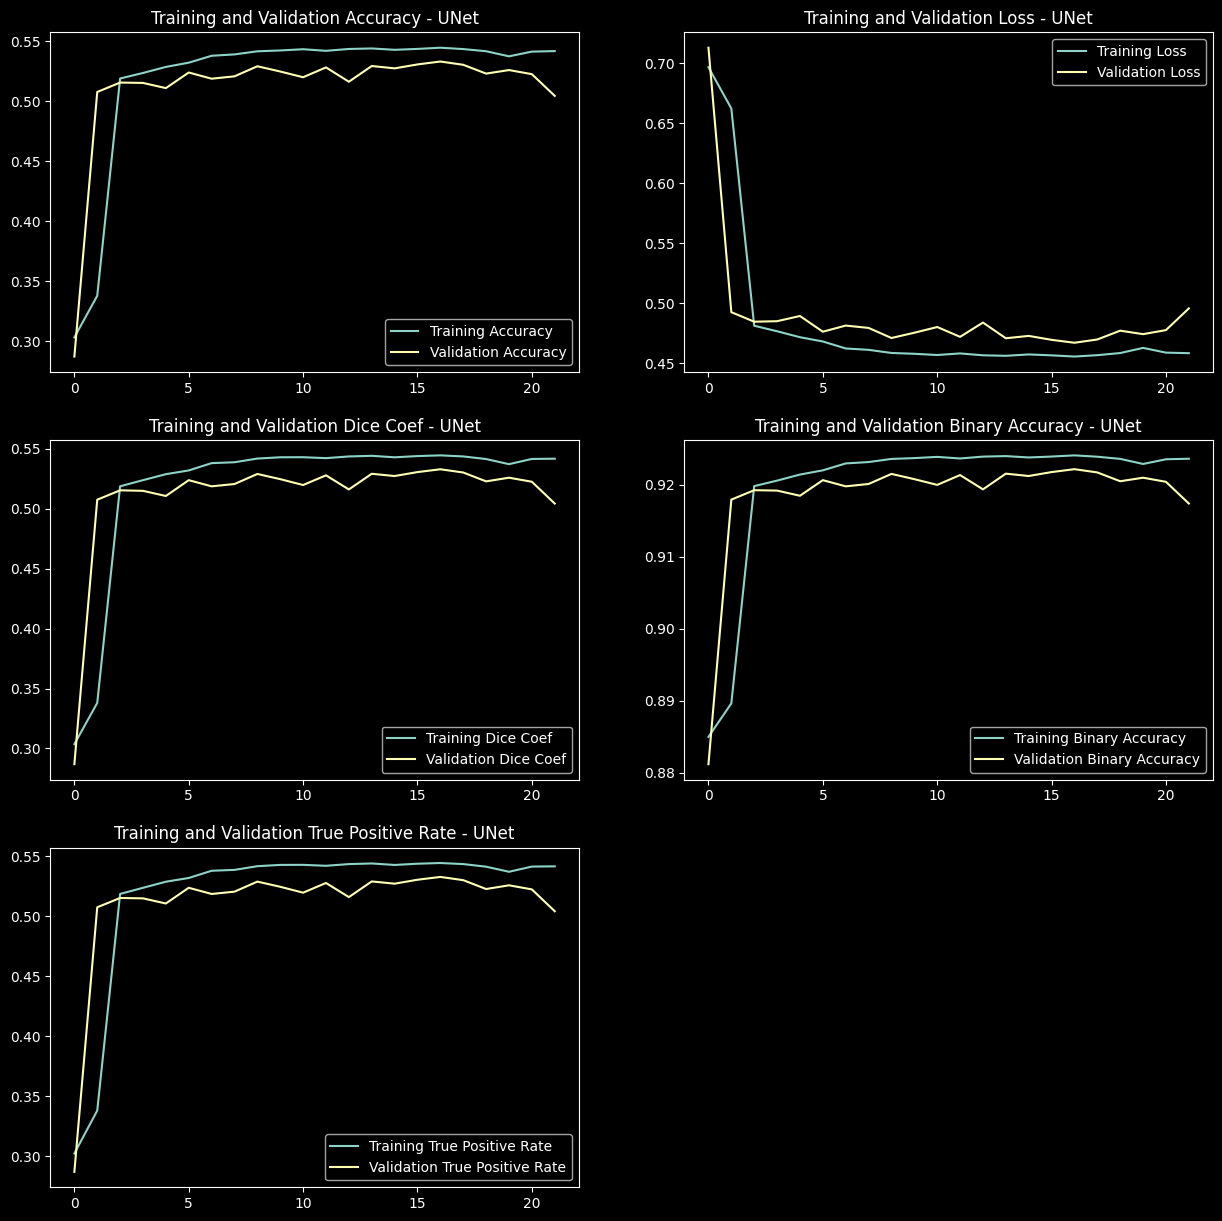

In [52]:
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title(f'Training and Validation Accuracy - UNet')

plt.subplot(3,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title(f'Training and Validation Loss - UNet')

plt.subplot(3,2,3)
plt.plot(epochs_range, dice, label='Training Dice Coef')
plt.plot(epochs_range, val_dice, label='Validation Dice Coef')
plt.legend(loc='best')
plt.title(f'Training and Validation Dice Coef - UNet')

plt.subplot(3,2,4)
plt.plot(epochs_range, bin_acc, label='Training Binary Accuracy')
plt.plot(epochs_range, val_bin_acc, label='Validation Binary Accuracy')
plt.legend(loc='best')
plt.title(f'Training and Validation Binary Accuracy - UNet')

plt.subplot(3,2,5)
plt.plot(epochs_range, tp_rate, label='Training True Positive Rate')
plt.plot(epochs_range, val_tp_rate, label='Validation True Positive Rate')
plt.legend(loc='best')
plt.title(f'Training and Validation True Positive Rate - UNet')
plt.show()

#### Model FCN8

In [34]:
# Plot training and validation
acc = history_fcn8.history['accuracy']
val_acc = history_fcn8.history['val_accuracy']
loss = history_fcn8.history['loss']
val_loss = history_fcn8.history['val_loss']
dice = history_fcn8.history['dice_coef']
val_dice = history_fcn8.history['val_dice_coef']
bin_acc = history_fcn8.history['binary_accuracy']
val_bin_acc = history_fcn8.history['val_binary_accuracy']
tp_rate = history_fcn8.history['true_positive_rate']
val_tp_rate = history_fcn8.history['val_true_positive_rate']

epochs_range = history_fcn8.epoch

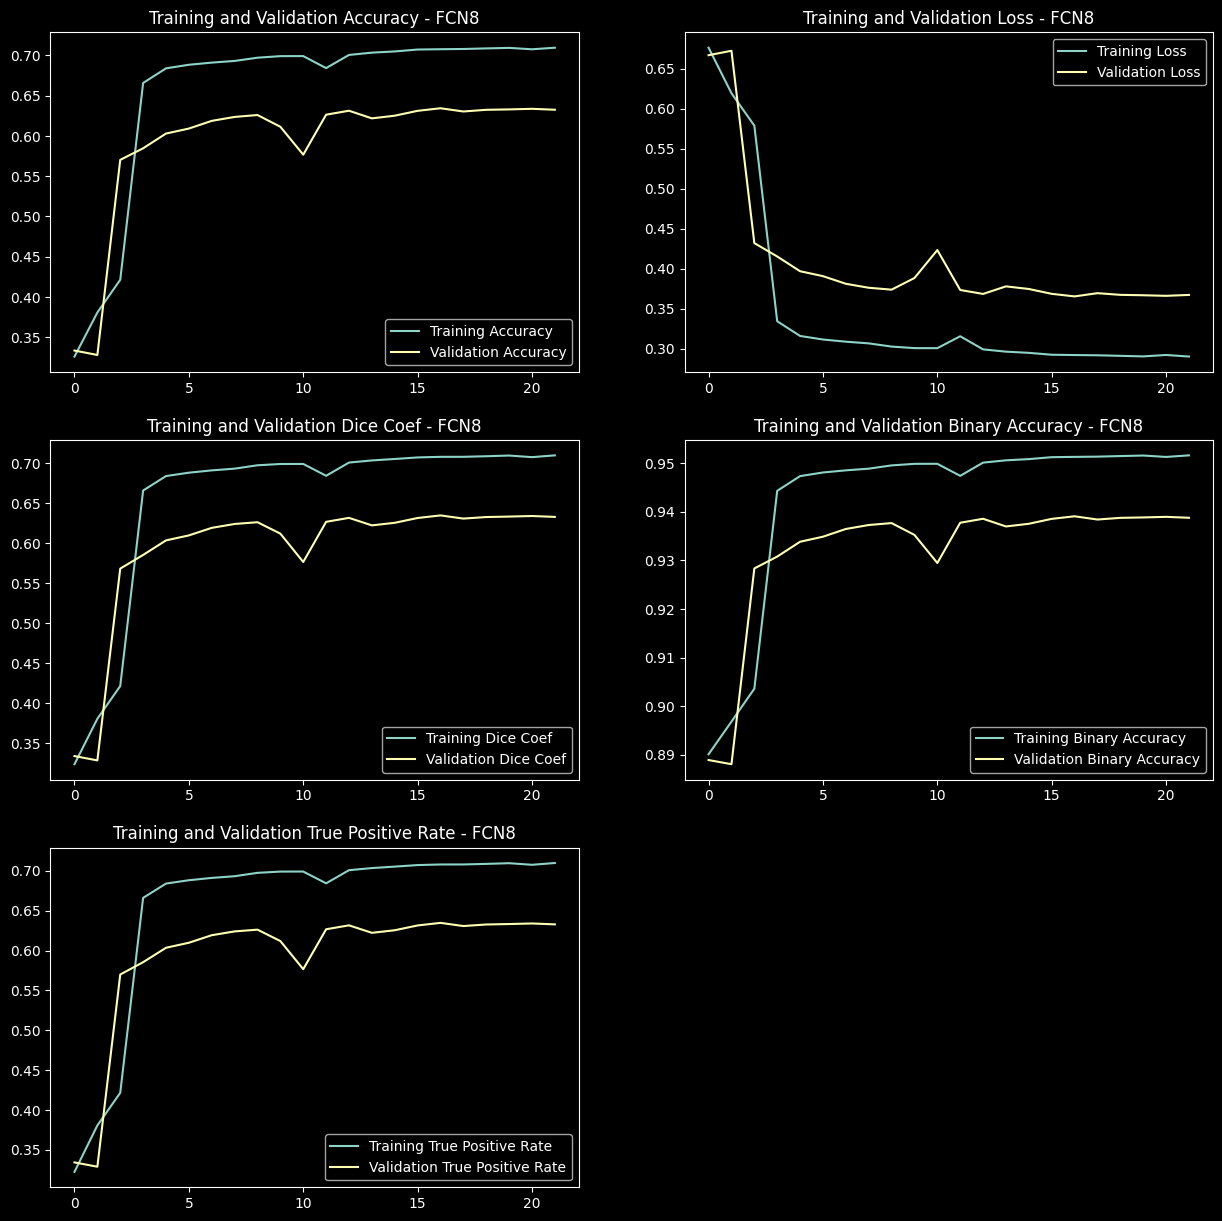

In [35]:
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title(f'Training and Validation Accuracy - FCN8')

plt.subplot(3,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title(f'Training and Validation Loss - FCN8')

plt.subplot(3,2,3)
plt.plot(epochs_range, dice, label='Training Dice Coef')
plt.plot(epochs_range, val_dice, label='Validation Dice Coef')
plt.legend(loc='best')
plt.title(f'Training and Validation Dice Coef - FCN8')

plt.subplot(3,2,4)
plt.plot(epochs_range, bin_acc, label='Training Binary Accuracy')
plt.plot(epochs_range, val_bin_acc, label='Validation Binary Accuracy')
plt.legend(loc='best')
plt.title(f'Training and Validation Binary Accuracy - FCN8')

plt.subplot(3,2,5)
plt.plot(epochs_range, tp_rate, label='Training True Positive Rate')
plt.plot(epochs_range, val_tp_rate, label='Validation True Positive Rate')
plt.legend(loc='best')
plt.title(f'Training and Validation True Positive Rate - FCN8')
plt.show()

## Evaluation

In [53]:
pred_test_unet = model_Unet.predict(test_x)
pred_test_fcn8 = model_FCN8.predict(test_x)

4/4 [==============================] - 1s 337ms/step


####Plot Predict UNet

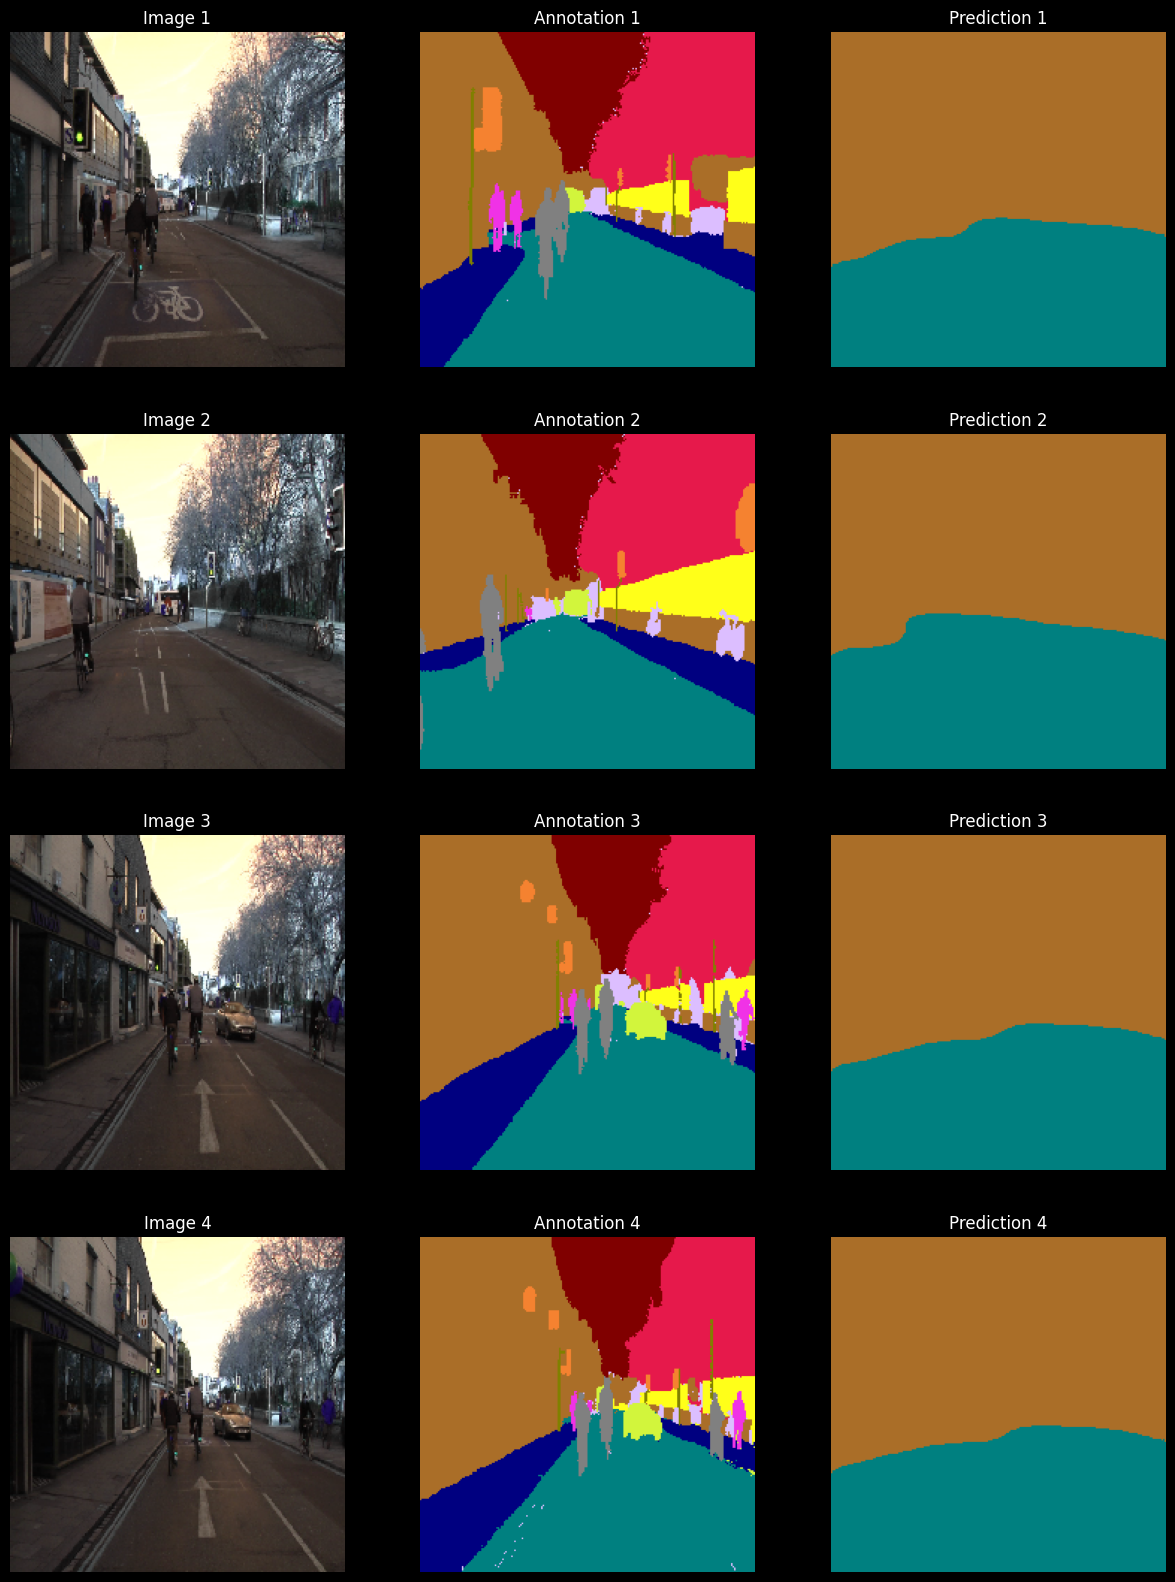

In [59]:
plt.figure(figsize=[15, 20])

for i in range(4):
  img = test_images[i]
  annotation = get_colored_segmentation_image(test_annotations[i],n_classes=12,colors=class_colors)
  # Menampilkan gambar prediksi segmentasi
  pred_seg = np.argmax(pred_test_unet[i], axis=-1)  # Mengambil saluran dengan nilai maksimal sebagai prediksi segmentasi
  colored_pred_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)

  for j in range(pred_seg.shape[0]):
    for k in range(pred_seg.shape[1]):
      colored_pred_seg[j, k] = class_colors[pred_seg[j, k]]

  plt.subplot(4, 3, i*3 + 1)
  plt.imshow(img)
  plt.axis('off')
  plt.gca().set_title('Image {}'.format(str(i+1)))

  plt.subplot(4, 3, i*3 + 2)
  plt.imshow(annotation)
  plt.axis('off')
  plt.gca().set_title('Annotation {}'.format(str(i+1)))

  plt.subplot(4, 3, i*3 + 3)
  plt.imshow(colored_pred_seg)
  plt.axis('off')
  plt.gca().set_title('Prediction {}'.format(str(i+1)))

####Plot Predict FCN8

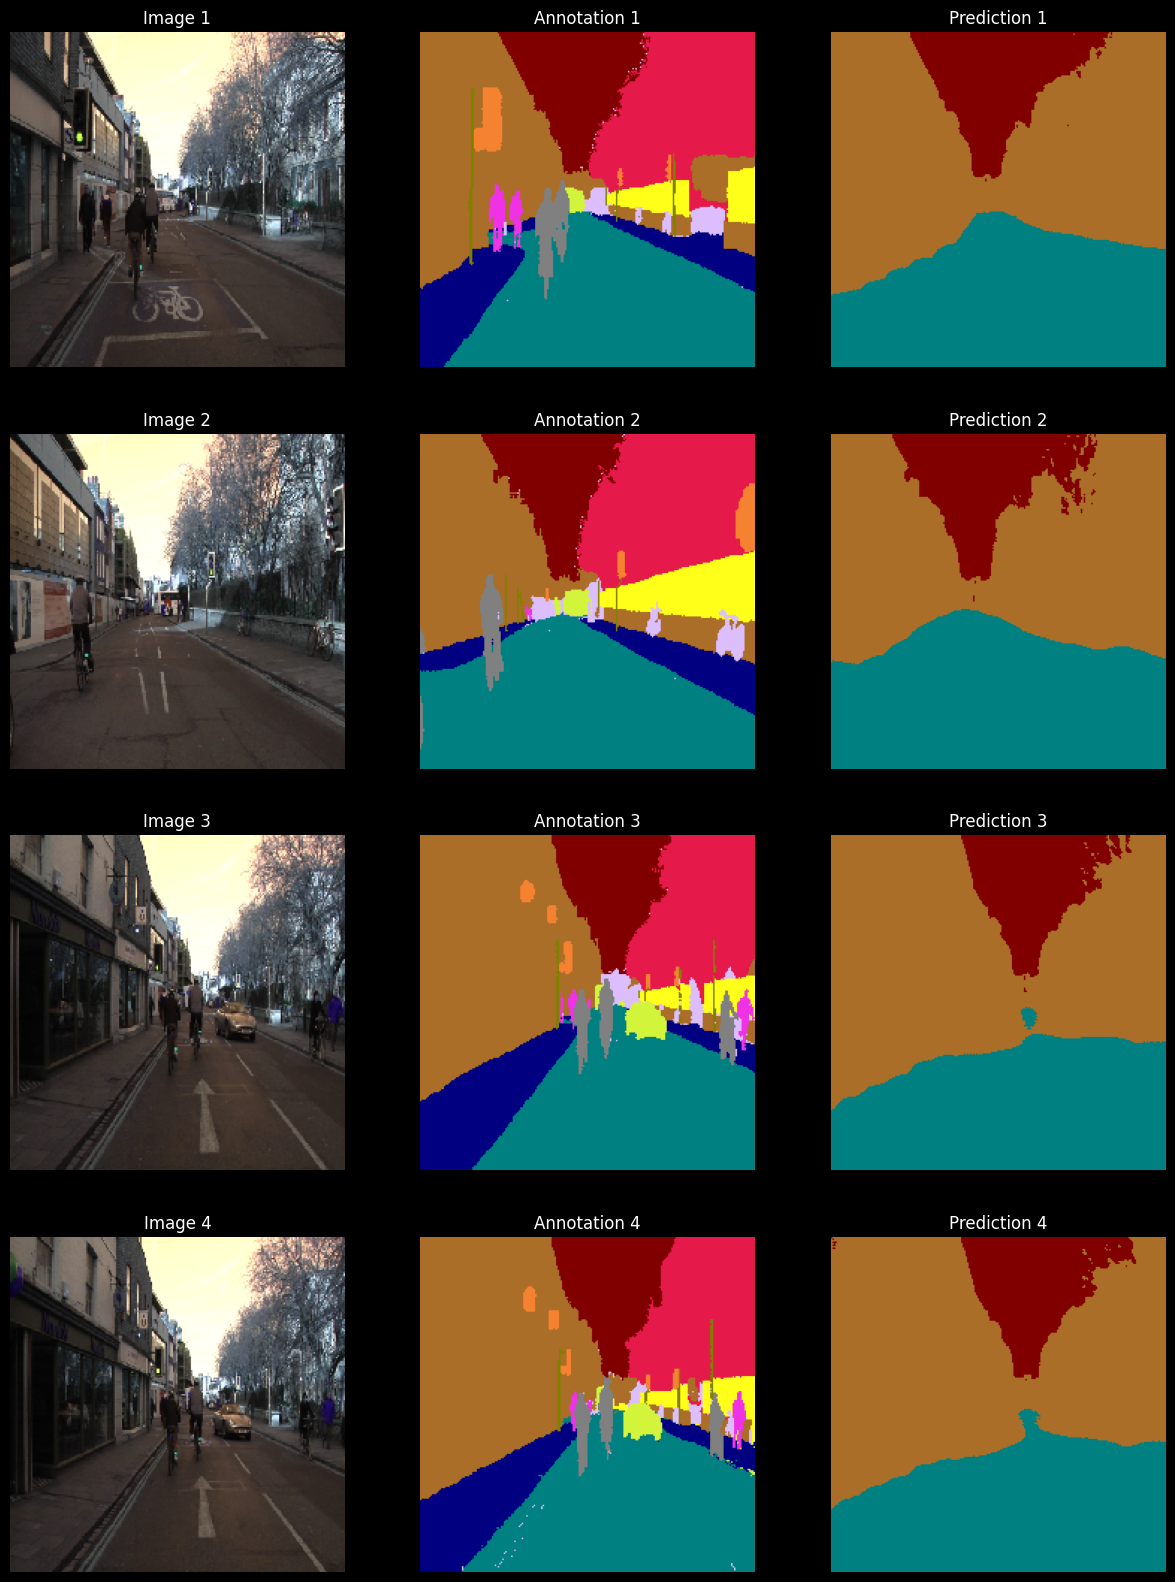

In [38]:
plt.figure(figsize=[15, 20])

for i in range(4):
  img = test_images[i]
  annotation = get_colored_segmentation_image(test_annotations[i],n_classes=12,colors=class_colors)
  # Menampilkan gambar prediksi segmentasi
  pred_seg = np.argmax(pred_test_fcn8[i], axis=-1)  # Mengambil saluran dengan nilai maksimal sebagai prediksi segmentasi
  colored_pred_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)

  for j in range(pred_seg.shape[0]):
    for k in range(pred_seg.shape[1]):
      colored_pred_seg[j, k] = class_colors[pred_seg[j, k]]

  plt.subplot(4, 3, i*3 + 1)
  plt.imshow(img)
  plt.axis('off')
  plt.gca().set_title('Image {}'.format(str(i+1)))

  plt.subplot(4, 3, i*3 + 2)
  plt.imshow(annotation)
  plt.axis('off')
  plt.gca().set_title('Annotation {}'.format(str(i+1)))

  plt.subplot(4, 3, i*3 + 3)
  plt.imshow(colored_pred_seg)
  plt.axis('off')
  plt.gca().set_title('Prediction {}'.format(str(i+1)))